In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

# Bayes Rule

** Data $x$ : ** 
* knowns / observed

** Parameters $\theta$ : ** 
* hypotheses / unknowns / estimated

** Prior $p(\theta)$ : **
* what do we know about $\theta_i$ prior to observing $x$?

**Likelihood $\mathcal{L}(x)$ = $p( x | \theta_i )$ : ** 
* what is the probability of observing $x$ given $\theta_i$ ?
* $\mathcal{L}(x)$ = $p( x | \theta_i )$

** Posterior $p(\theta | x)$ : **
* what is the probability of $\theta_i$, given that we've observed $x$?


$$p( \theta_i | x ) = \frac{p(x|\theta_i)p(\theta_i)}{\sum_i^n p(x|\theta_i)}$$

# Simple Example:

You take 10-question True/False quiz and answer 9 questions correctly. Based on this data, what can we infer about your true rate of answering T/F questions correctly? (Example from Lee & Wagenmakers, Cognitive Bayesian Modeling)

#### Data
* number of questions attempted (n)
* number of successes (s)
* $x = \{s, n\}$

#### Parameter of interest 
* Rate of answering a question correct, $\theta$

#### Prior,   $p(\theta)$ 
* $\theta \sim \mathcal{U}(0,1)$

#### Likelihood function: 
* $\mathcal{L}(x) = p(s|\theta,n) = \binom{n}{s}\theta^s(1-\theta)^{n-s}$

<img  src="img/graphicalModelBinomial.png"/ width=55%>

# Estimating the Posterior $p(\theta|x)$
#### Markov Chain Monte-Carlo (MCMC) Sampling
* Estimates Posterior probability density for all\* values of $\theta$ 

<img  src="img/rateParam_MCMC_chains.png"/ width="40%">

\* **all** meaning all values within specified range and precision

<img  src="img/MCMC_sampling_underPosterior.png"/ width="40%">

# Bayesian Regression Example

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pymc
from pymc3 import Model, Normal, HalfNormal
from scipy import optimize

## Generate Dataset (two predictors)

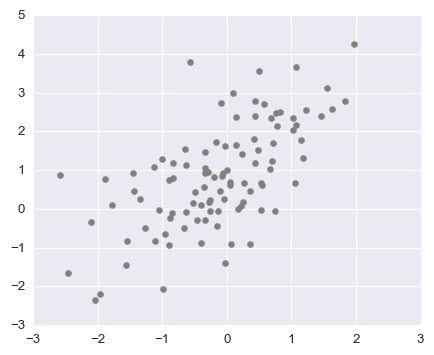

In [81]:
# "True" parameter values
#    alpha: intercept
#    beta: weights of X1 and X2 in predicting Y
#    sigma: some random noise  
alpha = 1
sigma = 1
beta = [1, 2.5]
# Number of observations (e.g., "subjects")
size = 100
# Predictor variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2
# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma
plt.scatter(X1, Y, color='Gray')

## Define multiple regression model (two predictors)

In [82]:
basic_model = Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

## Maximum a-posterior estimation (MAP)

Optimization terminated successfully.
         Current function value: 148.054964
         Iterations: 19
         Function evaluations: 26
         Gradient evaluations: 26
alpha=0.918699201077
beta=[ 1.0133  2.3048]
sigma_log_=-0.0422637602261


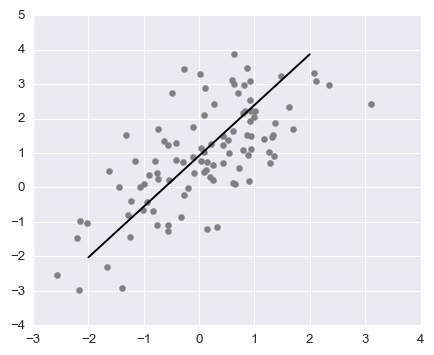

In [55]:
map_estimate = pymc.find_MAP(model=basic_model)
for k,v in map_estimate.items(): 
    print('{}={}'.format(k,v))

a = float(map_estimate['alpha'])
b1, b2 = map_estimate['beta']
x = np.linspace(-2, 2, 2)
yhat = a + b1*x + b2*x*.2

plt.scatter(X1, Y, color='Gray')
plt.plot(x, yhat, 'k')

## MCMC sampling of $\alpha$, $\beta_1$, $\beta_2$ posteriors

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -152.63: 100%|██████████| 200000/200000 [00:11<00:00, 17267.87it/s]
Finished [100%]: Average ELBO = -152.6
100%|██████████| 2000/2000 [00:02<00:00, 914.95it/s] 


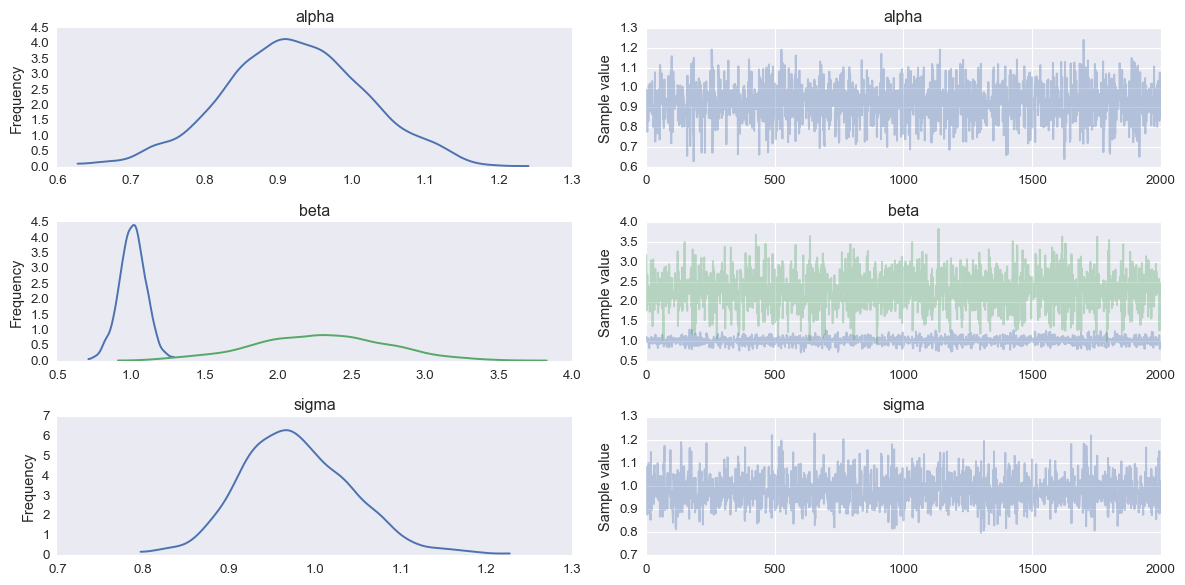

In [79]:
from pymc3 import NUTS, sample, traceplot
with basic_model:
    # draw 2000 posterior samples
    trace = sample(2000)
traceplot(trace);

In [78]:
# get MCMC sample traces 
aSamp = trace.get_values('alpha')
b1Samp, b2Samp = trace.get_values('beta').T

# calc mean of posterior samples
aMu = aSamp.mean()
b1Mu = b1Samp.mean()
b2Mu = b2Samp.mean()

# MCMC samples of posterior converge to MAP 
print(np.isclose(a, aMu, 1e-3))
print(np.isclose(b1, b1Mu, 1e-3))
print(np.isclose(b2, b2Mu, 1e-3))

True
True
True


# Misc Examples

## Signal Detection Theory (SDT)


#### Stochastic Parameters
* $c$ : Criterion
* $d$ : Stimulus Discriminability

#### Deterministic Parameters
* $h$ : Hit Rate
* $f$ : False-Alarm Rate

#### Observed Data
* $H$ : Number of Hits
* $F$ : Number of False Alarms

#### Constraints
* $S$ : Number of stimulus trials
* $N$ : Number of noise trials 

<img  src="img/graphicalmodel_standardSDT.png"/ width=65%>

## Hierarchical SDT

* $\mu$ and $\lambda$ hyperparameters are estimated for criterion ($c$) and discriminability ($d'$), representing the expected mean and variance of these parameters in the population


* individual subject estimates of $c_i$ and $d_i$ are sampled from the group-level distributions $(\mu_c, \lambda_c)$ and $(\mu_d, \lambda_d)$ 


<img  src="img/graphicalmodel_hierarchicalSDT.png"/ width=70%>

### Posterior distributions of $\mu_d$ & $\mu_c$ based on full MCMC chain

<img  src="img/jointPosterior_AllMCMCsamples.png"/ width=95%>

### Posterior SDT estimates with burn-in

<img  src="img/burnImprovedJointPosterior.png"/ width=97%>

## Parameters of a Gaussian 

<img  src="img/graphicalmodelGaussian.png"/ width=75%>